In [7]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from PIL import Image, ImageGrab


In [10]:
# Download data
import pathlib
data_dir = pathlib.Path(os.path.join(os.getcwd(), "data_bigtable"))
print(data_dir)
card_count = len(list(data_dir.glob('*/*.jpeg')))
print(card_count)


/Users/norme/Google-Drive/Programmering/Python/Poker/model/data_bigtable
332


In [11]:
# Create a training dataset and validation dataset
batch_size = 26
img_height = 50
img_width = 40
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Show batch size and shape.
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    print(labels_batch)
    break

# Labels from directory names
classes = train_ds.class_names
print(classes)

Found 332 files belonging to 52 classes.
Using 266 files for training.
Found 332 files belonging to 52 classes.
Using 66 files for validation.
(26, 50, 40, 3)
(26,)
tf.Tensor(
[30 26 21 12 26 15 37 28 17  3 29 36  2  4  9 32 37  2 32  9  0 43 42 51
 21 47], shape=(26,), dtype=int32)
['10C', '10D', '10H', '10S', '11C', '11D', '11H', '11S', '12C', '12D', '12H', '12S', '13C', '13D', '13H', '13S', '14C', '14D', '14H', '14S', '2C', '2D', '2H', '2S', '3C', '3D', '3H', '3S', '4C', '4D', '4H', '4S', '5C', '5D', '5H', '5S', '6C', '6D', '6H', '6S', '7C', '7D', '7H', '7S', '8C', '8D', '8H', '8S', '9C', '9D', '9H', '9S']


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [13]:
# Normalize and check pixels in range [0, 1]
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.22352943 1.0


In [36]:
# Create model and train 
num_classes = 52

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=1000
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/1000
11/11 [==============================] - 0s 33ms/step - loss: 3.9537 - accuracy: 0.0188 - val_loss: 3.9581 - val_accuracy: 0.0152
Epoch 2/1000
11/11 [==============================] - 0s 24ms/step - loss: 3.8842 - accuracy: 0.0263 - val_loss: 4.0063 - val_accuracy: 0.0152
Epoch 3/1000
11/11 [==============================] - 0s 24ms/step - loss: 3.8449 - accuracy: 0.0301 - val_loss: 3.9347 - val_accuracy: 0.0303
Epoch 4/1000
11/11 [==============================] - 0s 23ms/step - loss: 3.7396 - accuracy: 0.0789 - val_loss: 3.9427 - val_accuracy: 0.0303
Epoch 5/1000
11/11 [==============================] - 0s 23ms/step - loss: 3.5618 - accuracy: 0.0977 - val_loss: 3.7552 - val_accuracy: 0.0909
Epoch 6/1000
11/11 [==============================] - 0s 23ms/step - loss: 3.3344 - accuracy: 0.1353 - val_loss: 3.5822 - val_accuracy: 0.0909
Epoch 7/1000
11/11 [==============================] - 0s 24ms/step - loss: 3.1602 - accuracy: 0.1203 - val_loss: 3.3303 - val_accuracy: 0.1515

Epoch 58/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.7488 - accuracy: 0.7180 - val_loss: 0.6394 - val_accuracy: 0.7121
Epoch 59/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.7568 - accuracy: 0.7105 - val_loss: 0.6012 - val_accuracy: 0.8030
Epoch 60/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.7763 - accuracy: 0.7293 - val_loss: 0.6323 - val_accuracy: 0.7576
Epoch 61/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.6856 - accuracy: 0.7331 - val_loss: 0.5545 - val_accuracy: 0.7879
Epoch 62/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.6820 - accuracy: 0.7481 - val_loss: 0.5478 - val_accuracy: 0.7576
Epoch 63/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.6711 - accuracy: 0.7594 - val_loss: 0.5639 - val_accuracy: 0.7879
Epoch 64/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.6456 - accuracy: 0.7632 - val_loss: 0.6058 - val_accuracy:

Epoch 115/1000
11/11 [==============================] - 0s 25ms/step - loss: 0.2991 - accuracy: 0.8910 - val_loss: 0.2829 - val_accuracy: 0.8788
Epoch 116/1000
11/11 [==============================] - 0s 23ms/step - loss: 0.2384 - accuracy: 0.9135 - val_loss: 0.3028 - val_accuracy: 0.8636
Epoch 117/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.3357 - accuracy: 0.8797 - val_loss: 0.2649 - val_accuracy: 0.8939
Epoch 118/1000
11/11 [==============================] - 0s 23ms/step - loss: 0.2866 - accuracy: 0.8985 - val_loss: 0.3510 - val_accuracy: 0.8788
Epoch 119/1000
11/11 [==============================] - 0s 23ms/step - loss: 0.3651 - accuracy: 0.8759 - val_loss: 0.2954 - val_accuracy: 0.8939
Epoch 120/1000
11/11 [==============================] - 0s 23ms/step - loss: 0.3332 - accuracy: 0.8797 - val_loss: 0.3020 - val_accuracy: 0.8788
Epoch 121/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.3269 - accuracy: 0.8609 - val_loss: 0.3400 - val_ac

11/11 [==============================] - 0s 22ms/step - loss: 0.1510 - accuracy: 0.9398 - val_loss: 0.1955 - val_accuracy: 0.8939
Epoch 228/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.1654 - accuracy: 0.9248 - val_loss: 0.1056 - val_accuracy: 0.9545
Epoch 229/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.1006 - accuracy: 0.9662 - val_loss: 0.1533 - val_accuracy: 0.9545
Epoch 230/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.1154 - accuracy: 0.9662 - val_loss: 0.1123 - val_accuracy: 0.9545
Epoch 231/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.1215 - accuracy: 0.9474 - val_loss: 0.1295 - val_accuracy: 0.9545
Epoch 232/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.1433 - accuracy: 0.9323 - val_loss: 0.1077 - val_accuracy: 0.9697
Epoch 233/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.1504 - accuracy: 0.9286 - val_loss: 0.1459 - val_accuracy: 0.9242


11/11 [==============================] - 0s 21ms/step - loss: 0.1353 - accuracy: 0.9436 - val_loss: 0.1624 - val_accuracy: 0.9394
Epoch 340/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.1281 - accuracy: 0.9323 - val_loss: 0.0922 - val_accuracy: 0.9394
Epoch 341/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.1182 - accuracy: 0.9511 - val_loss: 0.0844 - val_accuracy: 0.9697
Epoch 342/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.1120 - accuracy: 0.9549 - val_loss: 0.1595 - val_accuracy: 0.9091
Epoch 343/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.1116 - accuracy: 0.9474 - val_loss: 0.1096 - val_accuracy: 0.9394
Epoch 344/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.0911 - accuracy: 0.9549 - val_loss: 0.0460 - val_accuracy: 0.9848
Epoch 345/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.1619 - accuracy: 0.9135 - val_loss: 0.2007 - val_accuracy: 0.9242


11/11 [==============================] - 0s 22ms/step - loss: 0.0687 - accuracy: 0.9624 - val_loss: 0.1421 - val_accuracy: 0.9545
Epoch 452/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.0643 - accuracy: 0.9737 - val_loss: 0.1233 - val_accuracy: 0.9545
Epoch 453/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.0672 - accuracy: 0.9586 - val_loss: 0.0811 - val_accuracy: 0.9697
Epoch 454/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.0674 - accuracy: 0.9662 - val_loss: 0.0624 - val_accuracy: 0.9697
Epoch 455/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.0910 - accuracy: 0.9549 - val_loss: 0.0586 - val_accuracy: 0.9697
Epoch 456/1000
11/11 [==============================] - 0s 23ms/step - loss: 0.0893 - accuracy: 0.9586 - val_loss: 0.0725 - val_accuracy: 0.9697
Epoch 457/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.1070 - accuracy: 0.9511 - val_loss: 0.1031 - val_accuracy: 0.9545


11/11 [==============================] - 0s 22ms/step - loss: 0.1140 - accuracy: 0.9624 - val_loss: 0.0661 - val_accuracy: 0.9848
Epoch 564/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.1007 - accuracy: 0.9474 - val_loss: 0.1074 - val_accuracy: 0.9697
Epoch 565/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.1121 - accuracy: 0.9474 - val_loss: 0.0829 - val_accuracy: 0.9394
Epoch 566/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.1798 - accuracy: 0.9286 - val_loss: 0.0917 - val_accuracy: 0.9697
Epoch 567/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.1290 - accuracy: 0.9398 - val_loss: 0.1956 - val_accuracy: 0.9697
Epoch 568/1000
11/11 [==============================] - 0s 23ms/step - loss: 0.1149 - accuracy: 0.9699 - val_loss: 0.0749 - val_accuracy: 0.9848
Epoch 569/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.1159 - accuracy: 0.9474 - val_loss: 0.1346 - val_accuracy: 0.9545


11/11 [==============================] - 0s 22ms/step - loss: 0.1253 - accuracy: 0.9586 - val_loss: 0.2354 - val_accuracy: 0.9091
Epoch 676/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.0929 - accuracy: 0.9511 - val_loss: 0.1279 - val_accuracy: 0.9394
Epoch 677/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.0899 - accuracy: 0.9699 - val_loss: 0.1397 - val_accuracy: 0.9394
Epoch 678/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.0605 - accuracy: 0.9774 - val_loss: 0.0792 - val_accuracy: 0.9697
Epoch 679/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.0630 - accuracy: 0.9774 - val_loss: 0.0655 - val_accuracy: 0.9697
Epoch 680/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.0499 - accuracy: 0.9812 - val_loss: 0.0600 - val_accuracy: 0.9697
Epoch 681/1000
11/11 [==============================] - 0s 23ms/step - loss: 0.0547 - accuracy: 0.9737 - val_loss: 0.0833 - val_accuracy: 0.9848


11/11 [==============================] - 0s 22ms/step - loss: 0.0488 - accuracy: 0.9737 - val_loss: 0.0479 - val_accuracy: 0.9848
Epoch 788/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.0429 - accuracy: 0.9850 - val_loss: 0.0429 - val_accuracy: 0.9848
Epoch 789/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.0418 - accuracy: 0.9850 - val_loss: 0.0559 - val_accuracy: 0.9848
Epoch 790/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.0572 - accuracy: 0.9662 - val_loss: 0.0530 - val_accuracy: 0.9848
Epoch 791/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.0591 - accuracy: 0.9774 - val_loss: 0.0632 - val_accuracy: 0.9848
Epoch 792/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.0514 - accuracy: 0.9699 - val_loss: 0.1056 - val_accuracy: 0.9242
Epoch 793/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.0753 - accuracy: 0.9662 - val_loss: 0.1231 - val_accuracy: 0.9697


11/11 [==============================] - 0s 22ms/step - loss: 0.0555 - accuracy: 0.9737 - val_loss: 0.1072 - val_accuracy: 0.9848
Epoch 900/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.0525 - accuracy: 0.9812 - val_loss: 0.0955 - val_accuracy: 0.9545
Epoch 901/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.0481 - accuracy: 0.9662 - val_loss: 0.0796 - val_accuracy: 0.9697
Epoch 902/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.0448 - accuracy: 0.9850 - val_loss: 0.0636 - val_accuracy: 0.9697
Epoch 903/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.0413 - accuracy: 0.9925 - val_loss: 0.0840 - val_accuracy: 0.9697
Epoch 904/1000
11/11 [==============================] - 0s 22ms/step - loss: 0.0390 - accuracy: 0.9774 - val_loss: 0.0919 - val_accuracy: 0.9697
Epoch 905/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.0326 - accuracy: 0.9887 - val_loss: 0.0856 - val_accuracy: 0.9697


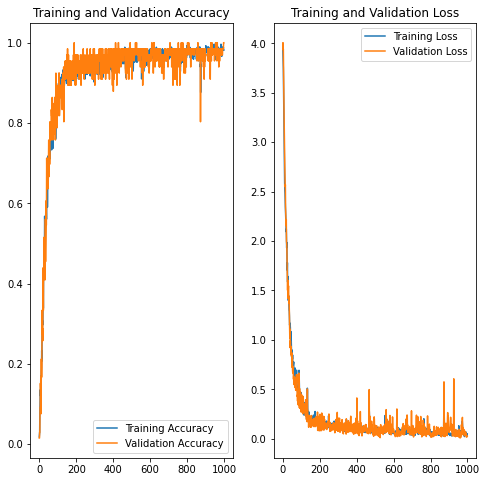

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [4]:
# Classify new data

data_dir = os.path.join(os.getcwd(), "data_bigtable_unsorted/9C.jpeg")
im = Image.open(data_dir)
arr = np.array(im)

img_array = tf.expand_dims(arr, 0) # Create a batch

predictions = model.predict(img_array)

score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[np.argmax(score)], 100 * np.max(score))
)


NameError: name 'model' is not defined

In [43]:

# SAVE MODEL IF NECESSARY
current_dir = os.getcwd()
model.save("PokerModel_bigtable")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: PokerModel_bigtable/assets
